# Happy Customers

## Goals

#### Predict if a customer is happy or not based on the answers they give to questions asked.
#### Bonus: Using a feature selection approach show us understand what is the minimal set of attributes/features that would preserve the most information about the problem while increasing predictability of the data we have. Is there any question that we can remove in our next survey?

## Success Criteria

#### Reach 73% accuracy score or above, or convince us why your solution is superior
#### Maximize Recall for Unhappy customers to assure issues are understood to prevent future unhappy customers.
#### Bonus:  Maintain or improve predictabilty using a reduced feature set.

In [6]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import warnings
import logging
import lazypredict
import random
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, make_scorer, recall_score
from sklearn.feature_selection import RFE
from lazypredict.Supervised import LazyClassifier
from hyperopt import fmin, tpe, hp, Trials
warnings.filterwarnings('ignore', category=UserWarning)

In [7]:
#seed = random.randint(1000,9999)
seed = 4547
print(seed)



4547


In [8]:
# download csv from google drive
url = f'https://drive.google.com/uc?id=1KWE3J0uU_sFIJnZ74Id3FDBcejELI7FD' 
output = 'happiness_survey.csv' # Download the file from Google Drive gdown.download(url, output, quiet=False) # Read the CSV file df = pd.read_csv(output)
# Download the file from Google Drive
gdown.download(url, output, quiet=False)
df=pd.read_csv(output)
df.head(5)

Downloading...
From: https://drive.google.com/uc?id=1KWE3J0uU_sFIJnZ74Id3FDBcejELI7FD
To: C:\Users\pddro\happiness_survey.csv
100%|█████████████████████████████████████████████████████████████████████████████| 1.91k/1.91k [00:00<00:00, 1.91MB/s]


,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [9]:
# check for missing values
df.isnull().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

In [10]:
# check data types
df.dtypes

Y     int64
X1    int64
X2    int64
X3    int64
X4    int64
X5    int64
X6    int64
dtype: object

In [11]:
#split data between target 'Y' and variables 'X'
X = df.drop('Y',axis=1)
Y = df['Y'].to_numpy()

In [12]:
X

,X1,X2,X3,X4,X5,X6
0,3,3,3,4,2,4
1,3,2,3,5,4,3
2,5,3,3,3,3,5
3,5,4,3,3,3,5
4,5,4,3,3,3,5
...,...,...,...,...,...,...
121,5,2,3,4,4,3
122,5,2,3,4,2,5
123,5,3,3,4,4,5
124,4,3,3,4,4,5


In [13]:
X_cols = X.columns

## Exploratory Data Analysis

In [15]:
df.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.00,126.00,126.00,126.00,126.00,126.00,126.00
mean,0.55,4.33,2.53,3.31,3.75,3.65,4.25
std,0.50,0.80,1.11,1.02,0.88,1.15,0.81
min,0.00,1.00,1.00,1.00,1.00,1.00,1.00
25%,0.00,4.00,2.00,3.00,3.00,3.00,4.00
50%,1.00,5.00,3.00,3.00,4.00,4.00,4.00
75%,1.00,5.00,3.00,4.00,4.00,4.00,5.00
max,1.00,5.00,5.00,5.00,5.00,5.00,5.00


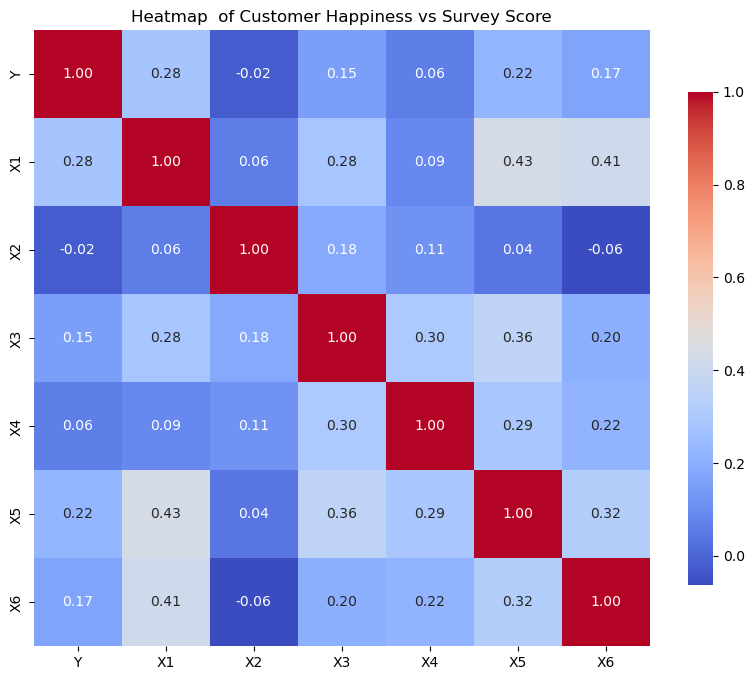

In [16]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Heatmap  of Customer Happiness vs Survey Score')

# Show the plot
plt.show()

#### No strong correlation between customer happiness and any indivual survey score.  No strong correlation between survey scores.

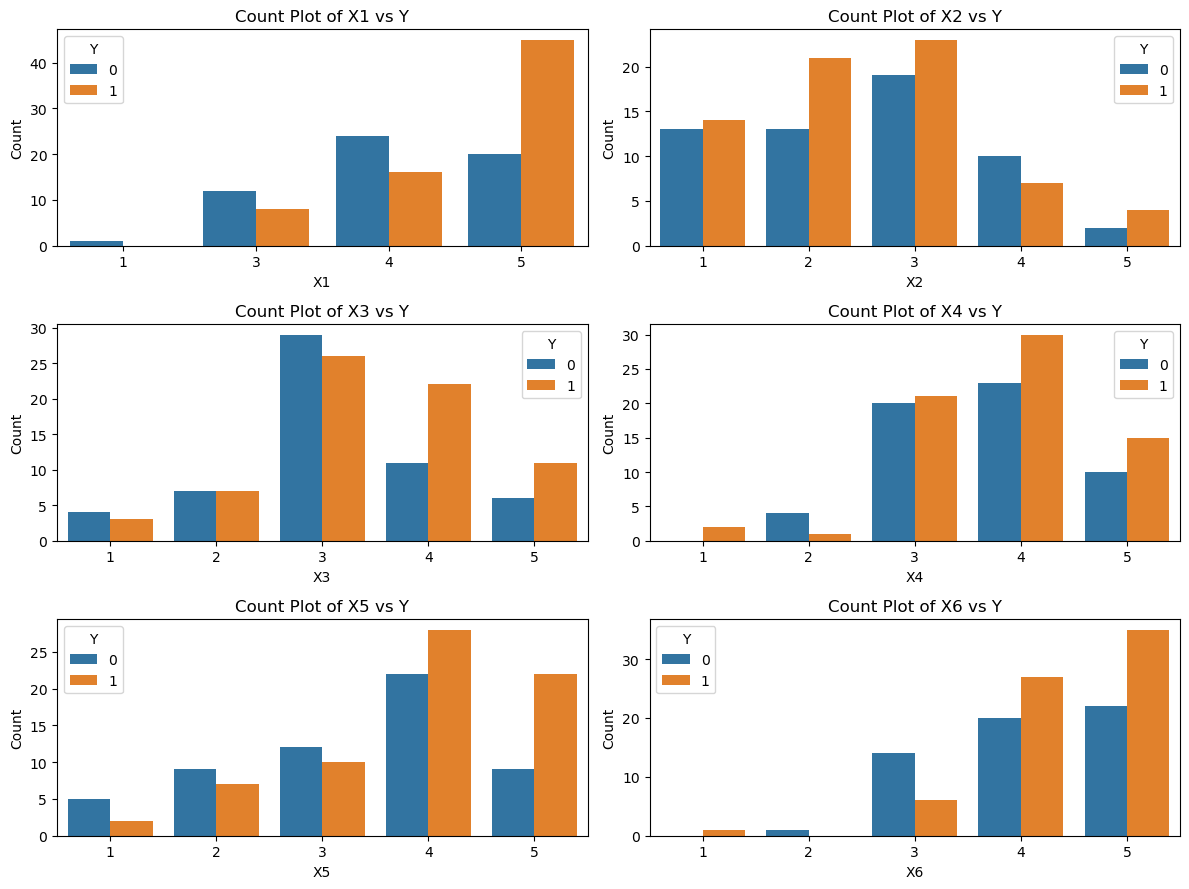

In [18]:
plt.figure(figsize=(12, 9))
for i, x_col in enumerate(X_cols):
    plt.subplot(3, 2, i + 1)
    sns.countplot(data=df, x=x_col, hue='Y')
    plt.title(f'Count Plot of {x_col} vs Y') 
    plt.xlabel(x_col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

##### X1:  The proportion of happy customers increases  as X1 score increases while unhappy customers remain relatively flat indicating is the most important feature for customer happiness.
##### X2:  No apparent relationship to customer happiness with a majority of happy and unhappy customers scoring X2 a 3 or less, indicating this is not a good prediction feature.  However, with very few scores of 4 or better it should be investigated what can be done to improve this score and if it would also improve customer happyiness. 
##### X3:  The number of unhappy customers drops greatly with X3 scores > 3.  The proportion of happy customers increases greatly with X3 scores of 4 or better, indicating this feature is important in predicting customer unhappiness.
##### X4:  Both happy and unhappy customers have similar trends indicating this is not a good predictive feature.
##### X5:  Unhappy customers drop significantly compared to happy customers X5 score of 5.  Possibly a good predictive feature for customer unhappiness.
##### X6:  Both happy and unhappy customers have similar trends indicating this is not a good predictive feature.

## Predictive Model Evaluation

In [21]:
# Split data in test and training sets
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=seed)

In [22]:
# define a confusion matrix plotter
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['unhappy', 'happy']); ax.yaxis.set_ticklabels(['unhappy', 'happy']) 
    plt.show() 

In [23]:
# code to suppress lightGBM when running Lazy Classifer
class CustomLogger:
    def __init__(self): 
        self.logger = logging.getLogger('lightgbm_custom') 
        self.logger.setLevel(logging.ERROR)
        
    def info(self, message): 
        self.logger.info(message) 
        
    def warning(self, message): 
        pass# Suppress warnings by not doing anything pass 
        
    def error(self, message): 
        self.logger.error(message) 
# Register the custom logger 
lgb.register_logger(CustomLogger())

### Base Model Training and hyper parameter optimization

#### Logistic Regression

In [26]:
# Define the objective function
def objective_lr(params):
    lr = LogisticRegression(**params, random_state=seed)
    lr.fit(X_train, y_train)
    pred_lr = lr.predict(X_test)
    accuracy = accuracy_score(y_test, pred_lr)
    return -accuracy

# Define the hyperparameter search space
search_lr = {
    'C': hp.loguniform('C', np.log(1e-4), np.log(1e2)),
    'solver': hp.choice('solver', ['liblinear', 'saga'])
}

# Minimize the objective function
trials_lr = Trials()
best_lr = fmin(fn=objective_lr,
            space=search_lr,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials_lr,
            rstate=np.random.default_rng(seed))

print("Best parameters found: ", best_lr) 

100%|████████████████████████████████████████████| 100/100 [00:00<00:00, 209.63trial/s, best loss: -0.7692307692307693]
Best parameters found:  {'C': 0.016620038399211053, 'solver': 0}


              precision    recall  f1-score   support

     Unhappy       1.00      0.25      0.40         8
       Happy       0.75      1.00      0.86        18

    accuracy                           0.77        26
   macro avg       0.88      0.62      0.63        26
weighted avg       0.83      0.77      0.72        26



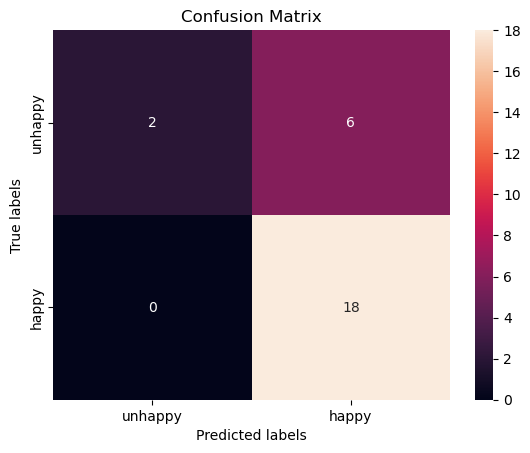

In [27]:
# Train logistic regression model with the best parameters
best_params_lr = {
    'C': best_lr['C'],
    'solver': ['liblinear', 'saga'][best_lr['solver']]
}
lr_best = lr=LogisticRegression(**best_params_lr, random_state=seed)
lr_best.fit(X_train, y_train)
y_pred = lr_best.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Unhappy', 'Happy'])
report_lr = classification_report(y_test, y_pred, target_names=['Unhappy', 'Happy'], output_dict=True)
recall_lr = report_lr['Unhappy']['recall']
print(report)
plot_confusion_matrix(y_test,y_pred)

#### Random Forest

In [29]:
# Define the objective function
def objective_rf(params):
    rf = RandomForestClassifier(**params, random_state=seed)
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_test)
    accuracy = accuracy_score(y_test, pred_rf)
    return -accuracy

# Define the hyperparameter search space
search_rf = {
    'n_estimators': hp.choice('n_estimators', range(10, 200)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

# Minimize the objective function
trials_rf = Trials()
best_rf = fmin(fn=objective_rf,
            space=search_rf,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials_rf,
            rstate=np.random.default_rng(seed))

print("Best parameters found: ", best_rf) 

100%|█████████████████████████████████████████████| 100/100 [00:08<00:00, 11.23trial/s, best loss: -0.8076923076923077]
Best parameters found:  {'criterion': 0, 'max_depth': 16, 'min_samples_leaf': 0, 'min_samples_split': 7, 'n_estimators': 24}


              precision    recall  f1-score   support

     Unhappy       0.67      0.75      0.71         8
       Happy       0.88      0.83      0.86        18

    accuracy                           0.81        26
   macro avg       0.77      0.79      0.78        26
weighted avg       0.82      0.81      0.81        26



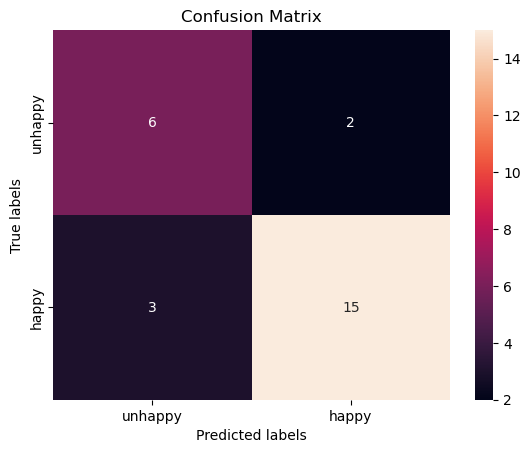

In [30]:
# Train random forest model with the best parameters
best_params_rf = {
    'n_estimators': range(10, 200)[best_rf['n_estimators']],
    'max_depth': range(1, 20)[best_rf['max_depth']],
    'min_samples_split': range(2, 11)[best_rf['min_samples_split']],
    'min_samples_leaf': range(1, 11)[best_rf['min_samples_leaf']],
    'criterion': ['gini', 'entropy'][best_rf['criterion']]
}
rf_best = RandomForestClassifier(**best_params_rf, random_state=seed)
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Unhappy', 'Happy'])
report_rf = classification_report(y_test, y_pred, target_names=['Unhappy', 'Happy'], output_dict=True)
recall_rf = report_rf['Unhappy']['recall']
print(report)
plot_confusion_matrix(y_test,y_pred)

#### Supervised Vector Classifier (SVC)

In [32]:
# Define the objective function
def objective_svc(params):
    svc = SVC(**params, random_state=seed)
    svc.fit(X_train, y_train)
    pred_svc = svc.predict(X_test)
    accuracy = accuracy_score(y_test, pred_svc)
    return -accuracy

# Define the hyperparameter search space
search_svc = {
    'C': hp.loguniform('C', np.log(1e-4), np.log(1e2)),
    #'kernel': hp.choice('kernel', ['linear', 'rbf', 'poly', 'sigmoid']),
    'kernel': hp.choice('kernel', ['linear']),
    'gamma': hp.choice('gamma', ['scale', 'auto']),
}

# Minimize the objective function
trials_svc = Trials()
best_svc = fmin(fn=objective_svc,
            space=search_svc,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials_svc,
            rstate=np.random.default_rng(seed))

print("Best parameters found: ", best_svc) 

100%|████████████████████████████████████████████| 100/100 [00:00<00:00, 234.07trial/s, best loss: -0.7307692307692307]
Best parameters found:  {'C': 0.016620038399211053, 'gamma': 0, 'kernel': 0}


              precision    recall  f1-score   support

     Unhappy       0.67      0.25      0.36         8
       Happy       0.74      0.94      0.83        18

    accuracy                           0.73        26
   macro avg       0.70      0.60      0.60        26
weighted avg       0.72      0.73      0.69        26



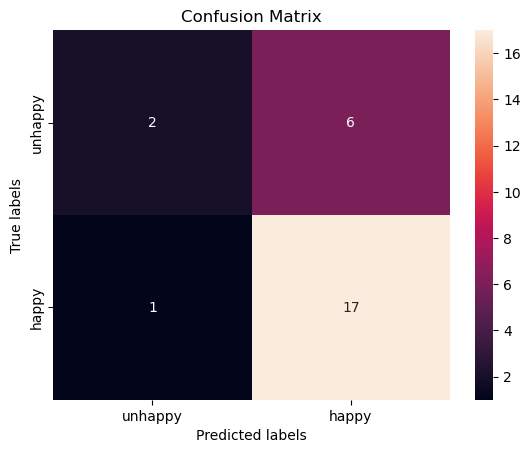

In [33]:
best_params_svc = {
    'C': best_svc['C'],
    #'kernel': ['linear', 'rbf', 'poly', 'sigmoid'][best_svc['kernel']],
    'kernel': ['linear'][best_svc['kernel']],
    'gamma': ['scale', 'auto'][best_svc['gamma']]
}
svc_best = SVC(**best_params_svc, random_state=seed)
svc_best.fit(X_train, y_train)
y_pred = svc_best.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Unhappy', 'Happy'])
report_svc = classification_report(y_test, y_pred, target_names=['Unhappy', 'Happy'], output_dict=True)
recall_svc = report_svc['Unhappy']['recall']
print(report)
plot_confusion_matrix(y_test,y_pred)

In [34]:
#create a dictionary with Unhappy recall scores for each model
recall_scores = {
    "LR recall: ": recall_lr,
    "RF recall: ": recall_rf,
    "SVC recall: ": recall_svc
}

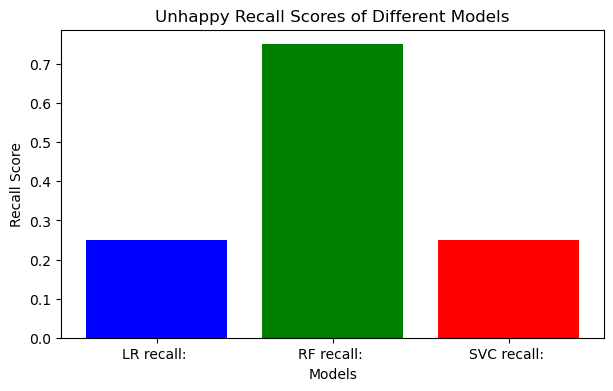

In [35]:
models = list(recall_scores.keys())
scores = list(recall_scores.values())
plt.figure(figsize=(7, 4))
plt.bar(models, scores, color=['blue', 'green', 'red'])
plt.title('Unhappy Recall Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('Recall Score')
plt.show()

## Model selection summary

##### While all 3 models had an accuracy of 0.73 or better, random forest had a significantly higher recall for Unhappy customers with a recall score of 0.75. 

## Feature selection

#### Recursive feature elimination (RFE) on random forest classifier to see if the model performs as good or better with a reduced feature set.

In [40]:
rf_best.fit(X_train, y_train)


recall_scores = []
for n_features in range(1, X_train.shape[1] + 1):
    # Initialize RFE
    rfe = RFE(estimator=rf_best, n_features_to_select=n_features)
    rfe.fit(X_train, y_train)
    
    # Perform cross-validation
    y_pred = rfe.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=['Unhappy', 'Happy'], output_dict=True) 
    recall = report['Unhappy']['recall']
    recall_scores.append((n_features,recall))
    
    
    #plot_confusion_matrix(y_test,y_pred)

# Find the number of features with the best score
best_n_features = max(recall_scores, key=lambda x: x[1])[0]
best_recall_score = max(recall_scores, key=lambda x: x[1])[1]
print(f'Optimal Number of Features: {best_n_features}')
print(f'Best recall score for Unhappy: {best_recall_score}')

# Use selected features to train the final model
rfe = RFE(estimator=rf_best, n_features_to_select=best_n_features)
fit = rfe.fit(X_train, y_train)
selected_features = X_train.columns[fit.support_]
print(f'Selected features: {selected_features}')

Optimal Number of Features: 3
Best recall score for Unhappy: 0.875
Selected features: Index(['X1', 'X3', 'X5'], dtype='object')


In [41]:
# retrain rf model on selected features and hyper 

X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Define the objective function
def objective_rf(params):
    rf = RandomForestClassifier(**params, random_state=seed)
    rf.fit(X_train_selected, y_train)
    pred_rf = rf.predict(X_test_selected)
    accuracy = accuracy_score(y_test, pred_rf)
    return -accuracy

# Define the hyperparameter search space
search_rf = {
    'n_estimators': hp.choice('n_estimators', range(10, 200)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 11)),
    'min_samples_leaf': hp.choice('min_samples_leaf', range(1, 11)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

# Minimize the objective function
trials_rf = Trials()
best_rf = fmin(fn=objective_rf,
            space=search_rf,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials_rf,
            rstate=np.random.default_rng(seed))

print("Best parameters found: ", best_rf) 

100%|█████████████████████████████████████████████| 100/100 [00:08<00:00, 11.52trial/s, best loss: -0.8076923076923077]
Best parameters found:  {'criterion': 0, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 1, 'n_estimators': 12}


              precision    recall  f1-score   support

     Unhappy       0.64      0.88      0.74         8
       Happy       0.93      0.78      0.85        18

    accuracy                           0.81        26
   macro avg       0.78      0.83      0.79        26
weighted avg       0.84      0.81      0.81        26



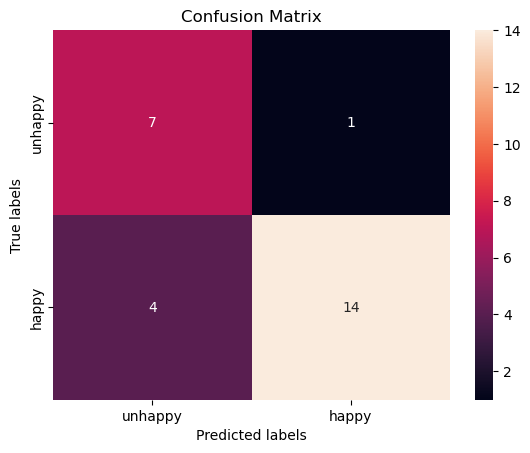

In [42]:
# Train random forest model with the best parameters
best_params_rf = {
    'n_estimators': range(10, 200)[best_rf['n_estimators']],
    'max_depth': range(1, 20)[best_rf['max_depth']],
    'min_samples_split': range(2, 11)[best_rf['min_samples_split']],
    'min_samples_leaf': range(1, 11)[best_rf['min_samples_leaf']],
    'criterion': ['gini', 'entropy'][best_rf['criterion']]
}
rf_best = RandomForestClassifier(**best_params_rf, random_state=seed)
rf_best.fit(X_train_selected, y_train)
y_pred = rf_best.predict(X_test_selected)
report = classification_report(y_test, y_pred, target_names=['Unhappy', 'Happy'])
print(report)
plot_confusion_matrix(y_test,y_pred)

#### RFE found the optimal number of features to be 3, keeping X1, X3, and X5, while eliminating, features X2, X4, and X6. Unhappy Recall improved from 0.75 to 0.88.  

## Conclusions

#### Following model evaluation and feature selection a random forest model was able to achieve a prediction accuracy of 81% and unhappy customer recall of 88%.  The features of most importance were found to be X1, X3, and X5, and it is recommended to remove X2, X4, and X6 from the next survey.